# Inspection angle span wrt 7m range threshold: spheroid comparison

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from pp_utils.core import generate_data_path_dict, MISC_PARAMS
from pp_utils.file_handling import df_main_loader
from pp_utils.trial_processor import TrialProcessor
from pp_utils import utils, utils_plot

In [4]:
import pickle

## Set paths, load main info df and clusters

In [5]:
data_path = generate_data_path_dict(Path("../data_processed/"))
raw_path = Path("../data_raw/")

### Data and output path

In [6]:
output_path = data_path["main"] / "data_summary"
tp_path = output_path / "trial_processor_object"

In [7]:
fig_path = Path("../figs")
if not fig_path.exists():
    fig_path.mkdir()

### Load main dataframe

In [8]:
df_main = df_main_loader(
    folder=data_path["info_csv"], filename="main_info_append_09.csv",
)

### Load compiled trial info and track portion

In [9]:
df_summary = pd.read_csv(output_path / "data_summary_all.csv", index_col=0)

In [10]:
with open(output_path / "track_portion_all.pickle", "rb") as filein:
    df_track_portion_all = pickle.load(filein)

## Spheroid names and colors

In [11]:
SPH_COLORS = ["w", "gainsboro", "darkgrey"]  # L, M, S

In [12]:
SPH_STR = ["L", "M", "S"]
SPH_LABEL = ["AR=2.9", "AR=1.3", "AR=1.1"]

## Gather data for inspection angle span before/after range threshold

- Range threshold: the elliptical distance from DTAG to both targets.
- Decision time: last click in the last scan to non-chosen target

Cases:
- before range threshold
- after range threshold but _before_ last inspection
- after range threshold but _including_ last inspection

In [13]:
# Range threshold
th_range = 7  # [m]

In [14]:
# Click RL threshold
MISC_PARAMS["th_RL"]

140

### Function

In [15]:
def get_angle_span_single_trial(trial_idx, filter_func):
    """
    Filter clicks and get angle span for a single trial.
    
    filter_func: one of the following:
        - filter_clicks_far
        - filter_clicks_close
        - filter_clicks_close_before_last_scan
    """
    # Load TrialProcessor object
    tp_obj_fname = tp_path / f"trial_{trial_idx:03d}.pickle"
    with open(tp_obj_fname, "rb") as filein:
        tp = pickle.load(filein)

    # Time when animal reaching range threshold
    time_range_th = utils.get_time_range_threshold(
        df_tr=tp.df_track.dropna(subset=["DTAG_dist_elliptical"]).copy(),
        th_range=th_range
    )

    # Filter clicks
    # time_last_scan_start is only used for filter_clicks_close_before_last_scan
    # time_far_start is only used for filter_clicks_far
    df_ch0 = filter_func(
        df_h=tp.df_hydro_ch0.copy(),
        th_RL=MISC_PARAMS["th_RL"],
        time_range_th=time_range_th,
        time_decision=tp.last_scan_end,
        time_last_scan_start=tp.last_scan_start,
        time_far_start=df_track_portion_all[trial_idx]["time_corrected"].values[0]
    )
    df_ch1 = filter_func(
        df_h=tp.df_hydro_ch1.copy(),
        th_RL=MISC_PARAMS["th_RL"],
        time_range_th=time_range_th,
        time_decision=tp.last_scan_end,
        time_last_scan_start=tp.last_scan_start,
        time_far_start=df_track_portion_all[trial_idx]["time_corrected"].values[0]
    )

    if isinstance(df_ch0, pd.DataFrame) and len(df_ch0) == 0:
        print(f"Trial {trial_idx}: df_ch0 is empty")
    if isinstance(df_ch1, pd.DataFrame) and len(df_ch1) == 0:
        print(f"Trial {trial_idx}: df_ch1 is empty")

    # Return inspection angle range
    return (
        df_ch0["enso_angle"].dropna().max() - df_ch0["enso_angle"].dropna().min(),
        df_ch1["enso_angle"].dropna().max() - df_ch1["enso_angle"].dropna().min()
    )

### Select trials to include

Criteria:
- `TRIAL_TO_INCLUDE==Y`
- contains valid track portion

In [16]:
angle_to_use = [False] * len(df_summary)

for trial_idx in df_summary.index:
    if df_track_portion_all[trial_idx] is None:
        angle_to_use[trial_idx] = False
    else:
        if df_main.iloc[trial_idx]["TRIAL_TO_INCLUDE"]=="N":
            angle_to_use[trial_idx] = False
        else:
            angle_to_use[trial_idx] = True

In [17]:
df_summary["angle_to_use"] = angle_to_use

In [18]:
df_summary["TCCT"] = df_main["LEFT"] + df_main["RIGHT"]

### Filter clicks > 7m elliptical distance: combine TC/CT trials

In [62]:
%%time
ch0_span_all_far = []
ch1_span_all_far = []
for sph in SPH_STR:
    
    df_c = df_summary[(df_summary["SPHEROID"]==sph) & df_summary["angle_to_use"]]
    
    ch0_span = np.nan * np.ones(len(df_c))
    ch1_span = np.nan * np.ones(len(df_c))
    for t_seq, trial_idx in enumerate(df_c.index):  # all trials in a cluster
        
        ch0_span[t_seq], ch1_span[t_seq] = get_angle_span_single_trial(
            trial_idx=trial_idx,
            filter_func=utils.filter_clicks_far
        )
    
    ch0_span_all_far.append(ch0_span)
    ch1_span_all_far.append(ch1_span)

CPU times: user 284 ms, sys: 34.5 ms, total: 318 ms
Wall time: 327 ms


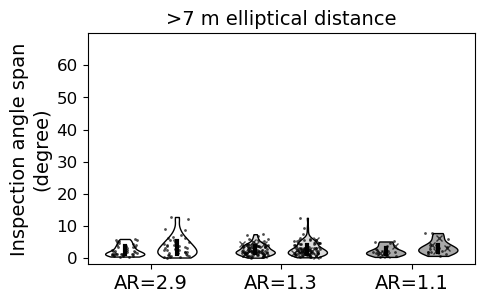

In [63]:
fig, ax=plt.subplots(1, 1, figsize=(5, 3))

for c_seq, c_sph, c_angle_ch0, c_angle_ch1, c_name, c_color in zip(
    np.arange(len(SPH_STR)),
    SPH_STR,
    ch0_span_all_far,
    ch1_span_all_far,
    SPH_LABEL,
    SPH_COLORS
):
    df_c = df_summary[(df_summary["SPHEROID"]==c_sph) & df_summary["angle_to_use"]]

    # Trials to be plotted as "x"
    idx_cross_all = df_c[df_c["time_buzz_onset_clean"] < df_c["time_decision"]].index
    
    # Determine index to be plotted as "x" and "."
    val_idx_cross = df_c.index.isin(idx_cross_all)
    val_idx_dot = ~df_c.index.isin(idx_cross_all)

    # Ch0
    utils_plot.plot_vio(
        axx=ax, vals=c_angle_ch0, seq=c_seq-0.2,
        color=c_color, widths=0.3, alpha=1, qbar_color="k", qbar_alpha=1
    )
    utils_plot.plot_jitter(
        axx=ax, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_dot],
        color="k", width=0.2, marker=".", markersize=4, markeredgewidth=0, alpha=0.7
    )
    utils_plot.plot_jitter(
        axx=ax, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_cross],
        color="k", width=0.2, marker="x", markersize=5, markeredgewidth=1, alpha=0.7
    )
    
    # Ch1
    utils_plot.plot_vio(
        axx=ax, vals=c_angle_ch1, seq=c_seq+0.2,
        color=c_color, widths=0.3, alpha=1, qbar_color="k", qbar_alpha=1
    )
    utils_plot.plot_jitter(
        axx=ax, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_dot],
        color="k", width=0.2, marker=".", markersize=4, markeredgewidth=0, alpha=0.7
    )
    utils_plot.plot_jitter(
        axx=ax, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_cross],
        color="k", width=0.2, marker="x", markersize=5, markeredgewidth=1, alpha=0.7
    )

# Axes setup
axx = ax
axx.set_xticks(np.arange(3))
axx.set_xticklabels(SPH_LABEL, fontsize=14)
axx.set_yticks(np.arange(0, 65, 10))
axx.set_yticklabels(np.arange(0, 65, 10), fontsize=12)
axx.set_ylim(-2, 70)
axx.set_ylabel("Inspection angle span\n(degree)", fontsize=14)
axx.set_title(">7 m elliptical distance", fontsize=14)
    
plt.show()

### Filter clicks > 7m elliptical distance: separate out TC/CT trials

In [64]:
%%time
ch0_span_all_far = {}
ch1_span_all_far = {}

for sph in SPH_STR:
    for tcct_type in ["TC", "CT"]:
    
        df_c = df_summary[
            (df_summary["SPHEROID"]==sph)
            & (df_summary["TCCT"]==tcct_type)
            & df_summary["angle_to_use"]
        ]

        ch0_span = np.nan * np.ones(len(df_c))
        ch1_span = np.nan * np.ones(len(df_c))
        for t_seq, trial_idx in enumerate(df_c.index):  # all trials in a cluster

            ch0_span[t_seq], ch1_span[t_seq] = get_angle_span_single_trial(
                trial_idx=trial_idx,
                filter_func=utils.filter_clicks_far
            )

        ch0_span_all_far[f"{sph}_{tcct_type}"] = ch0_span
        ch1_span_all_far[f"{sph}_{tcct_type}"] = ch1_span

CPU times: user 276 ms, sys: 36.9 ms, total: 313 ms
Wall time: 311 ms


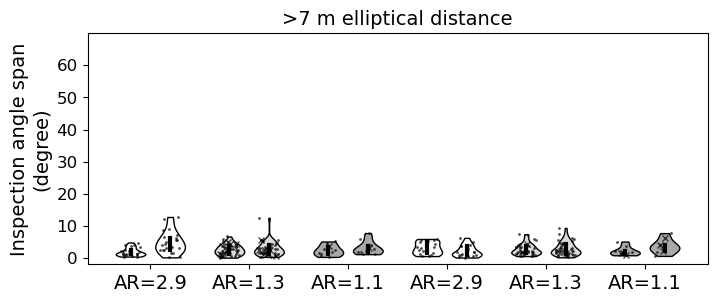

In [65]:
fig, ax=plt.subplots(1, 1, figsize=(8, 3))

for c_seq, c_sph, c_name, c_color in zip(
    np.arange(len(SPH_STR)),
    SPH_STR,
    SPH_LABEL,
    SPH_COLORS
):
    for tcct_type in ["TC", "CT"]:
        df_c = df_summary[
            (df_summary["SPHEROID"]==c_sph)
            & (df_summary["TCCT"]==tcct_type)
            & df_summary["angle_to_use"]
        ]
        c_angle_ch0 = ch0_span_all_far[f"{c_sph}_{tcct_type}"]
        c_angle_ch1 = ch1_span_all_far[f"{c_sph}_{tcct_type}"]

        # Trials to be plotted as "x"
        idx_cross_all = df_c[df_c["time_buzz_onset_clean"] < df_c["time_decision"]].index

        # Determine index to be plotted as "x" and "."
        val_idx_cross = df_c.index.isin(idx_cross_all)
        val_idx_dot = ~df_c.index.isin(idx_cross_all)

        c_seq = c_seq + 3 if tcct_type=="CT" else c_seq
        
        # Ch0
        utils_plot.plot_vio(
            axx=ax, vals=c_angle_ch0, seq=c_seq-0.2,
            color=c_color, widths=0.3, alpha=1, qbar_color="k", qbar_alpha=1
        )
        utils_plot.plot_jitter(
            axx=ax, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_dot],
            color="k", width=0.2, marker=".", markersize=4, markeredgewidth=0, alpha=0.7
        )
        utils_plot.plot_jitter(
            axx=ax, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_cross],
            color="k", width=0.2, marker="x", markersize=5, markeredgewidth=1, alpha=0.7
        )

        # Ch1
        utils_plot.plot_vio(
            axx=ax, vals=c_angle_ch1, seq=c_seq+0.2,
            color=c_color, widths=0.3, alpha=1, qbar_color="k", qbar_alpha=1
        )
        utils_plot.plot_jitter(
            axx=ax, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_dot],
            color="k", width=0.2, marker=".", markersize=4, markeredgewidth=0, alpha=0.7
        )
        utils_plot.plot_jitter(
            axx=ax, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_cross],
            color="k", width=0.2, marker="x", markersize=5, markeredgewidth=1, alpha=0.7
        )
    
    
# Axes setup
axx = ax
axx.set_xticks(np.arange(6))
axx.set_xticklabels(SPH_LABEL + SPH_LABEL, fontsize=14)
axx.set_yticks(np.arange(0, 65, 10))
axx.set_yticklabels(np.arange(0, 65, 10), fontsize=12)
axx.set_ylim(-2, 70)
axx.set_ylabel("Inspection angle span\n(degree)", fontsize=14)
axx.set_title(">7 m elliptical distance", fontsize=14)
    
plt.show()

### Filter clicks < 7m elliptical distance: combine TC/CT trials

In [66]:
%%time
ch0_span_all_close = []
ch1_span_all_close = []
for sph in SPH_STR:
    
    df_c = df_summary[(df_summary["SPHEROID"]==sph) & df_summary["angle_to_use"]]
    
    ch0_span = np.nan * np.ones(len(df_c))
    ch1_span = np.nan * np.ones(len(df_c))
    for t_seq, trial_idx in enumerate(df_c.index):  # all trials in a cluster
        
        ch0_span[t_seq], ch1_span[t_seq] = get_angle_span_single_trial(
            trial_idx=trial_idx,
            filter_func=utils.filter_clicks_close
        )

    ch0_span_all_close.append(ch0_span)
    ch1_span_all_close.append(ch1_span)

Trial 96: df_ch0 is empty
Trial 97: df_ch0 is empty
Trial 97: df_ch1 is empty
Trial 134: df_ch0 is empty
Trial 101: df_ch0 is empty
Trial 195: df_ch0 is empty
Trial 198: df_ch0 is empty
Trial 203: df_ch0 is empty
CPU times: user 320 ms, sys: 41.7 ms, total: 362 ms
Wall time: 373 ms


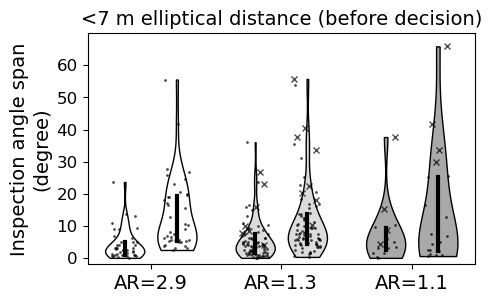

In [67]:
fig, ax=plt.subplots(1, 1, figsize=(5, 3))

for c_seq, c_sph, c_angle_ch0, c_angle_ch1, c_name, c_color in zip(
    np.arange(len(SPH_STR)),
    SPH_STR,
    ch0_span_all_close,
    ch1_span_all_close,
    SPH_LABEL,
    SPH_COLORS
):
    df_c = df_summary[(df_summary["SPHEROID"]==c_sph) & df_summary["angle_to_use"]]

    # Trials to be plotted as "x"
    idx_cross_all = df_c[df_c["time_buzz_onset_clean"] < df_c["time_decision"]].index
    
    # Determine index to be plotted as "x" and "."
    val_idx_cross = df_c.index.isin(idx_cross_all)
    val_idx_dot = ~df_c.index.isin(idx_cross_all)

    # Ch0
    utils_plot.plot_vio(
        axx=ax, vals=c_angle_ch0, seq=c_seq-0.2,
        color=c_color, widths=0.3, alpha=1, qbar_color="k", qbar_alpha=1
    )
    utils_plot.plot_jitter(
        axx=ax, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_dot],
        color="k", width=0.2, marker=".", markersize=4, markeredgewidth=0, alpha=0.7
    )
    utils_plot.plot_jitter(
        axx=ax, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_cross],
        color="k", width=0.2, marker="x", markersize=5, markeredgewidth=1, alpha=0.7
    )
    
    # Ch1
    utils_plot.plot_vio(
        axx=ax, vals=c_angle_ch1, seq=c_seq+0.2,
        color=c_color, widths=0.3, alpha=1, qbar_color="k", qbar_alpha=1
    )
    utils_plot.plot_jitter(
        axx=ax, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_dot],
        color="k", width=0.2, marker=".", markersize=4, markeredgewidth=0, alpha=0.7
    )
    utils_plot.plot_jitter(
        axx=ax, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_cross],
        color="k", width=0.2, marker="x", markersize=5, markeredgewidth=1, alpha=0.7
    )

# Axes setup
axx = ax
axx.set_xticks(np.arange(3))
axx.set_xticklabels(SPH_LABEL, fontsize=14)
axx.set_yticks(np.arange(0, 65, 10))
axx.set_yticklabels(np.arange(0, 65, 10), fontsize=12)
axx.set_ylim(-2, 70)
axx.set_ylabel("Inspection angle span\n(degree)", fontsize=14)
axx.set_title("<7 m elliptical distance (before decision)", fontsize=14)
    
plt.show()

### Filter clicks < 7m elliptical distance: separate out TC/CT trials

In [68]:
%%time
ch0_span_all_close = {}
ch1_span_all_close = {}

for sph in SPH_STR:
    for tcct_type in ["TC", "CT"]:
    
        df_c = df_summary[
            (df_summary["SPHEROID"]==sph)
            & (df_summary["TCCT"]==tcct_type)
            & df_summary["angle_to_use"]
        ]

        ch0_span = np.nan * np.ones(len(df_c))
        ch1_span = np.nan * np.ones(len(df_c))
        for t_seq, trial_idx in enumerate(df_c.index):  # all trials in a cluster

            ch0_span[t_seq], ch1_span[t_seq] = get_angle_span_single_trial(
                trial_idx=trial_idx,
                filter_func=utils.filter_clicks_close
            )

        ch0_span_all_close[f"{sph}_{tcct_type}"] = ch0_span
        ch1_span_all_close[f"{sph}_{tcct_type}"] = ch1_span

Trial 96: df_ch0 is empty
Trial 97: df_ch0 is empty
Trial 97: df_ch1 is empty
Trial 134: df_ch0 is empty
Trial 101: df_ch0 is empty
Trial 195: df_ch0 is empty
Trial 198: df_ch0 is empty
Trial 203: df_ch0 is empty
CPU times: user 286 ms, sys: 36.1 ms, total: 322 ms
Wall time: 321 ms


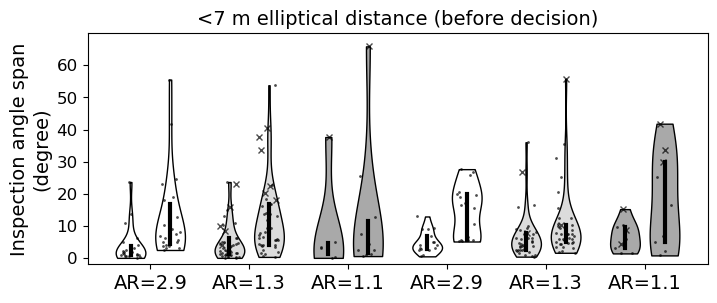

In [69]:
fig, ax=plt.subplots(1, 1, figsize=(8, 3))

for c_seq, c_sph, c_name, c_color in zip(
    np.arange(len(SPH_STR)),
    SPH_STR,
    SPH_LABEL,
    SPH_COLORS
):
    for tcct_type in ["TC", "CT"]:
        df_c = df_summary[
            (df_summary["SPHEROID"]==c_sph)
            & (df_summary["TCCT"]==tcct_type)
            & df_summary["angle_to_use"]
        ]
        c_angle_ch0 = ch0_span_all_close[f"{c_sph}_{tcct_type}"]
        c_angle_ch1 = ch1_span_all_close[f"{c_sph}_{tcct_type}"]

        # Trials to be plotted as "x"
        idx_cross_all = df_c[df_c["time_buzz_onset_clean"] < df_c["time_decision"]].index

        # Determine index to be plotted as "x" and "."
        val_idx_cross = df_c.index.isin(idx_cross_all)
        val_idx_dot = ~df_c.index.isin(idx_cross_all)

        c_seq = c_seq + 3 if tcct_type=="CT" else c_seq
        
        # Ch0
        utils_plot.plot_vio(
            axx=ax, vals=c_angle_ch0, seq=c_seq-0.2,
            color=c_color, widths=0.3, alpha=1, qbar_color="k", qbar_alpha=1
        )
        utils_plot.plot_jitter(
            axx=ax, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_dot],
            color="k", width=0.2, marker=".", markersize=4, markeredgewidth=0, alpha=0.7
        )
        utils_plot.plot_jitter(
            axx=ax, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_cross],
            color="k", width=0.2, marker="x", markersize=5, markeredgewidth=1, alpha=0.7
        )

        # Ch1
        utils_plot.plot_vio(
            axx=ax, vals=c_angle_ch1, seq=c_seq+0.2,
            color=c_color, widths=0.3, alpha=1, qbar_color="k", qbar_alpha=1
        )
        utils_plot.plot_jitter(
            axx=ax, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_dot],
            color="k", width=0.2, marker=".", markersize=4, markeredgewidth=0, alpha=0.7
        )
        utils_plot.plot_jitter(
            axx=ax, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_cross],
            color="k", width=0.2, marker="x", markersize=5, markeredgewidth=1, alpha=0.7
        )
    
    
# Axes setup
axx = ax
axx.set_xticks(np.arange(6))
axx.set_xticklabels(SPH_LABEL + SPH_LABEL, fontsize=14)
axx.set_yticks(np.arange(0, 65, 10))
axx.set_yticklabels(np.arange(0, 65, 10), fontsize=12)
axx.set_ylim(-2, 70)
axx.set_ylabel("Inspection angle span\n(degree)", fontsize=14)
axx.set_title("<7 m elliptical distance (before decision)", fontsize=14)
    
plt.show()

### Filter clicks < 7m elliptical distance but before last scan: combine TC/CT trials

In [70]:
%%time
ch0_span_all_close_before_last_scan = []
ch1_span_all_close_before_last_scan = []
for sph in SPH_STR:
    
    df_c = df_summary[(df_summary["SPHEROID"]==sph) & df_summary["angle_to_use"]]
    
    ch0_span = np.nan * np.ones(len(df_c))
    ch1_span = np.nan * np.ones(len(df_c))
    for t_seq, trial_idx in enumerate(df_c.index):  # all trials in a cluster
        
        ch0_span[t_seq], ch1_span[t_seq] = get_angle_span_single_trial(
            trial_idx=trial_idx,
            filter_func=utils.filter_clicks_close_before_last_scan
        )

    ch0_span_all_close_before_last_scan.append(ch0_span)
    ch1_span_all_close_before_last_scan.append(ch1_span)

Trial 26: df_ch0 is empty
Trial 40: df_ch1 is empty
Trial 44: df_ch1 is empty
Trial 48: df_ch1 is empty
Trial 62: df_ch1 is empty
Trial 89: df_ch1 is empty
Trial 96: df_ch0 is empty
Trial 96: df_ch1 is empty
Trial 97: df_ch0 is empty
Trial 97: df_ch1 is empty
Trial 132: df_ch1 is empty
Trial 134: df_ch0 is empty
Trial 134: df_ch1 is empty
Trial 186: df_ch0 is empty
Trial 186: df_ch1 is empty
Trial 190: df_ch1 is empty
Trial 192: df_ch1 is empty
Trial 101: df_ch0 is empty
Trial 101: df_ch1 is empty
Trial 102: df_ch1 is empty
Trial 195: df_ch0 is empty
Trial 195: df_ch1 is empty
Trial 198: df_ch0 is empty
Trial 198: df_ch1 is empty
Trial 203: df_ch0 is empty
CPU times: user 297 ms, sys: 37.8 ms, total: 335 ms
Wall time: 333 ms


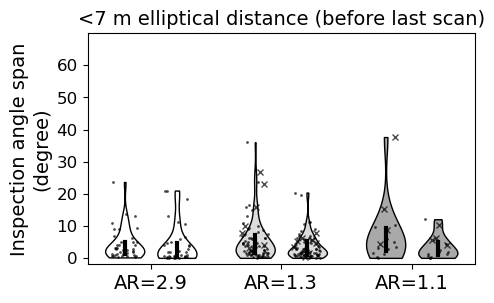

In [71]:
fig, ax=plt.subplots(1, 1, figsize=(5, 3))

for c_seq, c_sph, c_angle_ch0, c_angle_ch1, c_name, c_color in zip(
    np.arange(len(SPH_STR)),
    SPH_STR,
    ch0_span_all_close_before_last_scan,
    ch1_span_all_close_before_last_scan,
    SPH_LABEL,
    SPH_COLORS
):
    df_c = df_summary[(df_summary["SPHEROID"]==c_sph) & df_summary["angle_to_use"]]

    # Trials to be plotted as "x"
    idx_cross_all = df_c[df_c["time_buzz_onset_clean"] < df_c["time_decision"]].index
    
    # Determine index to be plotted as "x" and "."
    val_idx_cross = df_c.index.isin(idx_cross_all)
    val_idx_dot = ~df_c.index.isin(idx_cross_all)

    # Ch0
    utils_plot.plot_vio(
        axx=ax, vals=c_angle_ch0, seq=c_seq-0.2,
        color=c_color, widths=0.3, alpha=1, qbar_color="k", qbar_alpha=1
    )
    utils_plot.plot_jitter(
        axx=ax, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_dot],
        color="k", width=0.2, marker=".", markersize=4, markeredgewidth=0, alpha=0.7
    )
    utils_plot.plot_jitter(
        axx=ax, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_cross],
        color="k", width=0.2, marker="x", markersize=5, markeredgewidth=1, alpha=0.7
    )
    
    # Ch1
    utils_plot.plot_vio(
        axx=ax, vals=c_angle_ch1, seq=c_seq+0.2,
        color=c_color, widths=0.3, alpha=1, qbar_color="k", qbar_alpha=1
    )
    utils_plot.plot_jitter(
        axx=ax, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_dot],
        color="k", width=0.2, marker=".", markersize=4, markeredgewidth=0, alpha=0.7
    )
    utils_plot.plot_jitter(
        axx=ax, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_cross],
        color="k", width=0.2, marker="x", markersize=5, markeredgewidth=1, alpha=0.7
    )

# Axes setup
axx = ax
axx.set_xticks(np.arange(3))
axx.set_xticklabels(SPH_LABEL, fontsize=14)
axx.set_yticks(np.arange(0, 65, 10))
axx.set_yticklabels(np.arange(0, 65, 10), fontsize=12)
axx.set_ylim(-2, 70)
axx.set_ylabel("Inspection angle span\n(degree)", fontsize=14)
axx.set_title("<7 m elliptical distance (before last scan)", fontsize=14)
    
plt.show()

### Filter clicks < 7m elliptical distance but before last scan: separate out TC/CT trials

In [72]:
%%time
ch0_span_all_close_before_last_scan = {}
ch1_span_all_close_before_last_scan = {}

for sph in SPH_STR:
    for tcct_type in ["TC", "CT"]:
    
        df_c = df_summary[
            (df_summary["SPHEROID"]==sph)
            & (df_summary["TCCT"]==tcct_type)
            & df_summary["angle_to_use"]
        ]

        ch0_span = np.nan * np.ones(len(df_c))
        ch1_span = np.nan * np.ones(len(df_c))
        for t_seq, trial_idx in enumerate(df_c.index):  # all trials in a cluster

            ch0_span[t_seq], ch1_span[t_seq] = get_angle_span_single_trial(
                trial_idx=trial_idx,
                filter_func=utils.filter_clicks_close_before_last_scan
            )

        ch0_span_all_close_before_last_scan[f"{sph}_{tcct_type}"] = ch0_span
        ch1_span_all_close_before_last_scan[f"{sph}_{tcct_type}"] = ch1_span

Trial 26: df_ch0 is empty
Trial 40: df_ch1 is empty
Trial 44: df_ch1 is empty
Trial 48: df_ch1 is empty
Trial 62: df_ch1 is empty
Trial 89: df_ch1 is empty
Trial 96: df_ch0 is empty
Trial 96: df_ch1 is empty
Trial 97: df_ch0 is empty
Trial 97: df_ch1 is empty
Trial 132: df_ch1 is empty
Trial 134: df_ch0 is empty
Trial 134: df_ch1 is empty
Trial 186: df_ch0 is empty
Trial 186: df_ch1 is empty
Trial 190: df_ch1 is empty
Trial 192: df_ch1 is empty
Trial 101: df_ch0 is empty
Trial 101: df_ch1 is empty
Trial 195: df_ch0 is empty
Trial 195: df_ch1 is empty
Trial 198: df_ch0 is empty
Trial 198: df_ch1 is empty
Trial 203: df_ch0 is empty
Trial 102: df_ch1 is empty
CPU times: user 298 ms, sys: 32.5 ms, total: 331 ms
Wall time: 329 ms


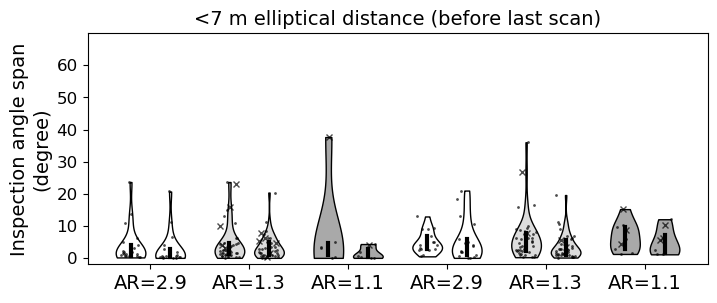

In [73]:
fig, ax=plt.subplots(1, 1, figsize=(8, 3))

for c_seq, c_sph, c_name, c_color in zip(
    np.arange(len(SPH_STR)),
    SPH_STR,
    SPH_LABEL,
    SPH_COLORS
):
    for tcct_type in ["TC", "CT"]:
        df_c = df_summary[
            (df_summary["SPHEROID"]==c_sph)
            & (df_summary["TCCT"]==tcct_type)
            & df_summary["angle_to_use"]
        ]
        c_angle_ch0 = ch0_span_all_close_before_last_scan[f"{c_sph}_{tcct_type}"]
        c_angle_ch1 = ch1_span_all_close_before_last_scan[f"{c_sph}_{tcct_type}"]

        # Trials to be plotted as "x"
        idx_cross_all = df_c[df_c["time_buzz_onset_clean"] < df_c["time_decision"]].index

        # Determine index to be plotted as "x" and "."
        val_idx_cross = df_c.index.isin(idx_cross_all)
        val_idx_dot = ~df_c.index.isin(idx_cross_all)

        c_seq = c_seq + 3 if tcct_type=="CT" else c_seq
        
        # Ch0
        utils_plot.plot_vio(
            axx=ax, vals=c_angle_ch0, seq=c_seq-0.2,
            color=c_color, widths=0.3, alpha=1, qbar_color="k", qbar_alpha=1
        )
        utils_plot.plot_jitter(
            axx=ax, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_dot],
            color="k", width=0.2, marker=".", markersize=4, markeredgewidth=0, alpha=0.7
        )
        utils_plot.plot_jitter(
            axx=ax, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_cross],
            color="k", width=0.2, marker="x", markersize=5, markeredgewidth=1, alpha=0.7
        )

        # Ch1
        utils_plot.plot_vio(
            axx=ax, vals=c_angle_ch1, seq=c_seq+0.2,
            color=c_color, widths=0.3, alpha=1, qbar_color="k", qbar_alpha=1
        )
        utils_plot.plot_jitter(
            axx=ax, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_dot],
            color="k", width=0.2, marker=".", markersize=4, markeredgewidth=0, alpha=0.7
        )
        utils_plot.plot_jitter(
            axx=ax, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_cross],
            color="k", width=0.2, marker="x", markersize=5, markeredgewidth=1, alpha=0.7
        )
    
    
# Axes setup
axx = ax
axx.set_xticks(np.arange(6))
axx.set_xticklabels(SPH_LABEL + SPH_LABEL, fontsize=14)
axx.set_yticks(np.arange(0, 65, 10))
axx.set_yticklabels(np.arange(0, 65, 10), fontsize=12)
axx.set_ylim(-2, 70)
axx.set_ylabel("Inspection angle span\n(degree)", fontsize=14)
axx.set_title("<7 m elliptical distance (before last scan)", fontsize=14)
    
plt.show()

## Put panels together

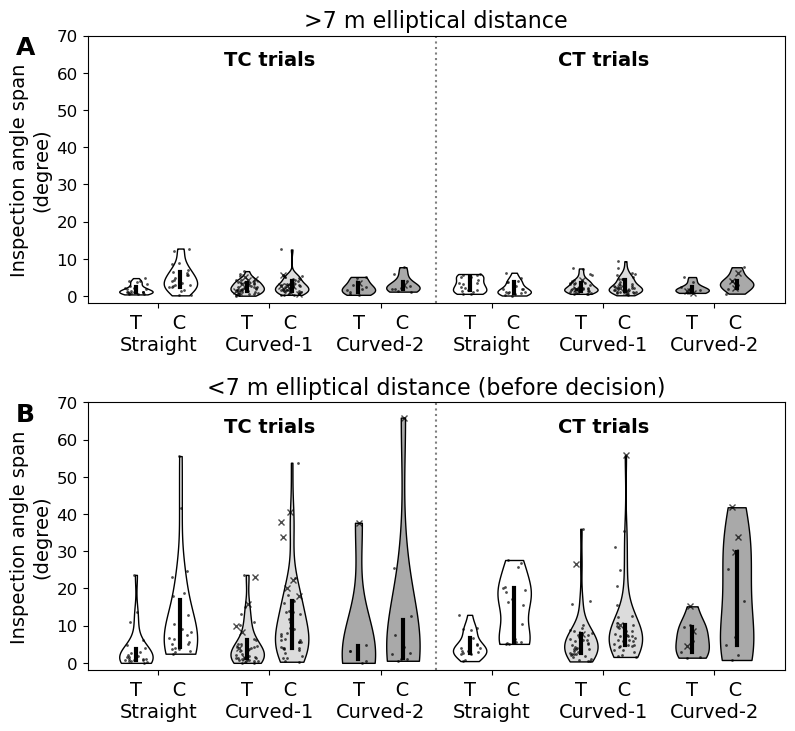

In [86]:
plot_track_opt = True  # set to False for quickly tuning fig


fig, ax = plt.subplots(2, 1, figsize=(9, 8), facecolor="w")

plt.subplots_adjust(hspace=0.3)


# =================================
# Inspection angle span > 7m
# =================================
ax_angle_far = ax[0]

for c_seq, c_sph, c_name, c_color in zip(
    np.arange(len(SPH_STR)), SPH_STR, SPH_LABEL, SPH_COLORS
):
    for tcct_type in ["TC", "CT"]:
        df_c = df_summary[
            (df_summary["SPHEROID"]==c_sph)
            & (df_summary["TCCT"]==tcct_type)
            & df_summary["angle_to_use"]
        ]
        c_angle_ch0 = ch0_span_all_far[f"{c_sph}_{tcct_type}"]
        c_angle_ch1 = ch1_span_all_far[f"{c_sph}_{tcct_type}"]

        # Trials to be plotted as "x"
        idx_cross_all = df_c[df_c["time_buzz_onset_clean"] < df_c["time_decision"]].index

        # Determine index to be plotted as "x" and "."
        val_idx_cross = df_c.index.isin(idx_cross_all)
        val_idx_dot = ~df_c.index.isin(idx_cross_all)

        c_seq = c_seq + 3 if tcct_type=="CT" else c_seq
        
        # Ch0
        utils_plot.plot_vio(
            axx=ax_angle_far, vals=c_angle_ch0, seq=c_seq-0.2,
            color=c_color, widths=0.3, alpha=1, qbar_color="k", qbar_alpha=1
        )
        utils_plot.plot_jitter(
            axx=ax_angle_far, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_dot],
            color="k", width=0.2, marker=".", markersize=4, markeredgewidth=0, alpha=0.7
        )
        utils_plot.plot_jitter(
            axx=ax_angle_far, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_cross],
            color="k", width=0.2, marker="x", markersize=5, markeredgewidth=1, alpha=0.7
        )

        # Ch1
        utils_plot.plot_vio(
            axx=ax_angle_far, vals=c_angle_ch1, seq=c_seq+0.2,
            color=c_color, widths=0.3, alpha=1, qbar_color="k", qbar_alpha=1
        )
        utils_plot.plot_jitter(
            axx=ax_angle_far, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_dot],
            color="k", width=0.2, marker=".", markersize=4, markeredgewidth=0, alpha=0.7
        )
        utils_plot.plot_jitter(
            axx=ax_angle_far, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_cross],
            color="k", width=0.2, marker="x", markersize=5, markeredgewidth=1, alpha=0.7
        )


# =================================
# Inspection angle span < 7m
# =================================
ax_angle_close = ax[1]

for c_seq, c_sph, c_name, c_color in zip(
    np.arange(len(SPH_STR)), SPH_STR, SPH_LABEL, SPH_COLORS
):
    for tcct_type in ["TC", "CT"]:
        df_c = df_summary[
            (df_summary["SPHEROID"]==c_sph)
            & (df_summary["TCCT"]==tcct_type)
            & df_summary["angle_to_use"]
        ]
        c_angle_ch0 = ch0_span_all_close[f"{c_sph}_{tcct_type}"]
        c_angle_ch1 = ch1_span_all_close[f"{c_sph}_{tcct_type}"]

        # Trials to be plotted as "x"
        idx_cross_all = df_c[df_c["time_buzz_onset_clean"] < df_c["time_decision"]].index

        # Determine index to be plotted as "x" and "."
        val_idx_cross = df_c.index.isin(idx_cross_all)
        val_idx_dot = ~df_c.index.isin(idx_cross_all)

        c_seq = c_seq + 3 if tcct_type=="CT" else c_seq
        
        # Ch0
        utils_plot.plot_vio(
            axx=ax_angle_close, vals=c_angle_ch0, seq=c_seq-0.2,
            color=c_color, widths=0.3, alpha=1, qbar_color="k", qbar_alpha=1
        )
        utils_plot.plot_jitter(
            axx=ax_angle_close, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_dot],
            color="k", width=0.2, marker=".", markersize=4, markeredgewidth=0, alpha=0.7
        )
        utils_plot.plot_jitter(
            axx=ax_angle_close, x_pos=c_seq-0.2, vals=c_angle_ch0[val_idx_cross],
            color="k", width=0.2, marker="x", markersize=5, markeredgewidth=1, alpha=0.7
        )

        # Ch1
        utils_plot.plot_vio(
            axx=ax_angle_close, vals=c_angle_ch1, seq=c_seq+0.2,
            color=c_color, widths=0.3, alpha=1, qbar_color="k", qbar_alpha=1
        )
        utils_plot.plot_jitter(
            axx=ax_angle_close, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_dot],
            color="k", width=0.2, marker=".", markersize=4, markeredgewidth=0, alpha=0.7
        )
        utils_plot.plot_jitter(
            axx=ax_angle_close, x_pos=c_seq+0.2, vals=c_angle_ch1[val_idx_cross],
            color="k", width=0.2, marker="x", markersize=5, markeredgewidth=1, alpha=0.7
        )


# Axes setup
for axx in [ax_angle_far, ax_angle_close]:
    axx.set_xticks(np.arange(6))
    axx.set_xticklabels(
        ["T     C\nStraight", "T     C\nCurved-1", "T     C\nCurved-2",
         "T     C\nStraight", "T     C\nCurved-1", "T     C\nCurved-2"],
        fontsize=14, 
    )
    axx.set_yticks(np.arange(0, 75, 10))
    axx.set_yticklabels(np.arange(0, 75, 10), fontsize=12)
    axx.set_ylim(-2, 70)
    axx.set_ylabel("Inspection angle span\n(degree)", fontsize=14)
    axx.axvline(2.5, color="grey", ls=":")
    axx.text(1, 62, "TC trials", fontsize=14,  fontweight="bold", ha="center")
    axx.text(4, 62, "CT trials", fontsize=14,  fontweight="bold", ha="center")

ax_angle_far.set_title(">7 m elliptical distance", fontsize=16)
ax_angle_close.set_title("<7 m elliptical distance (before decision)", fontsize=16)

# Adjust bottom 2 axes vertical location
ax_pos = ax_angle_far.get_position()
ax_angle_far.set_position([
    ax_pos.x0, ax_pos.y0-ax_pos.height*0.07, ax_pos.width, ax_pos.height
])
ax_pos = ax_angle_close.get_position()
ax_angle_close.set_position([
    ax_pos.x0, ax_pos.y0-ax_pos.height*0.14, ax_pos.width, ax_pos.height
])

# Add panel labels
ax_angle_far.text(-1.28, 65, "A", fontsize=18, fontweight="bold")
ax_angle_close.text(-1.28, 65, "B", fontsize=18, fontweight="bold")

plt.show()

fig.savefig(fig_path / "fig_cluster_angle_span_allAR.png", dpi=300, bbox_inches="tight")
